In [31]:
raw_adata = adata.raw.to_adata()

In [32]:
import numpy as np

# Create a mask for values greater than 0
if isinstance(raw_adata[:, "CHAT"].X, np.ndarray):
    # X is already dense
    mask = (raw_adata[:, "CHAT"].X > 0).flatten()
else:
    # X is sparse; convert to dense
    mask = (raw_adata[:, "CHAT"].X > 0).toarray().flatten()

# Copy "cell_type" to a new column "fine"
raw_adata.obs["fine"] = raw_adata.obs["cell_type"].copy()

# Add a new category "ChN" if not already present
if "ChN" not in raw_adata.obs["fine"].cat.categories:
    raw_adata.obs["fine"] = raw_adata.obs["fine"].cat.add_categories("ChN")

# Assign "ChN" to cells where the mask is True
raw_adata.obs.loc[mask, "fine"] = "ChN"


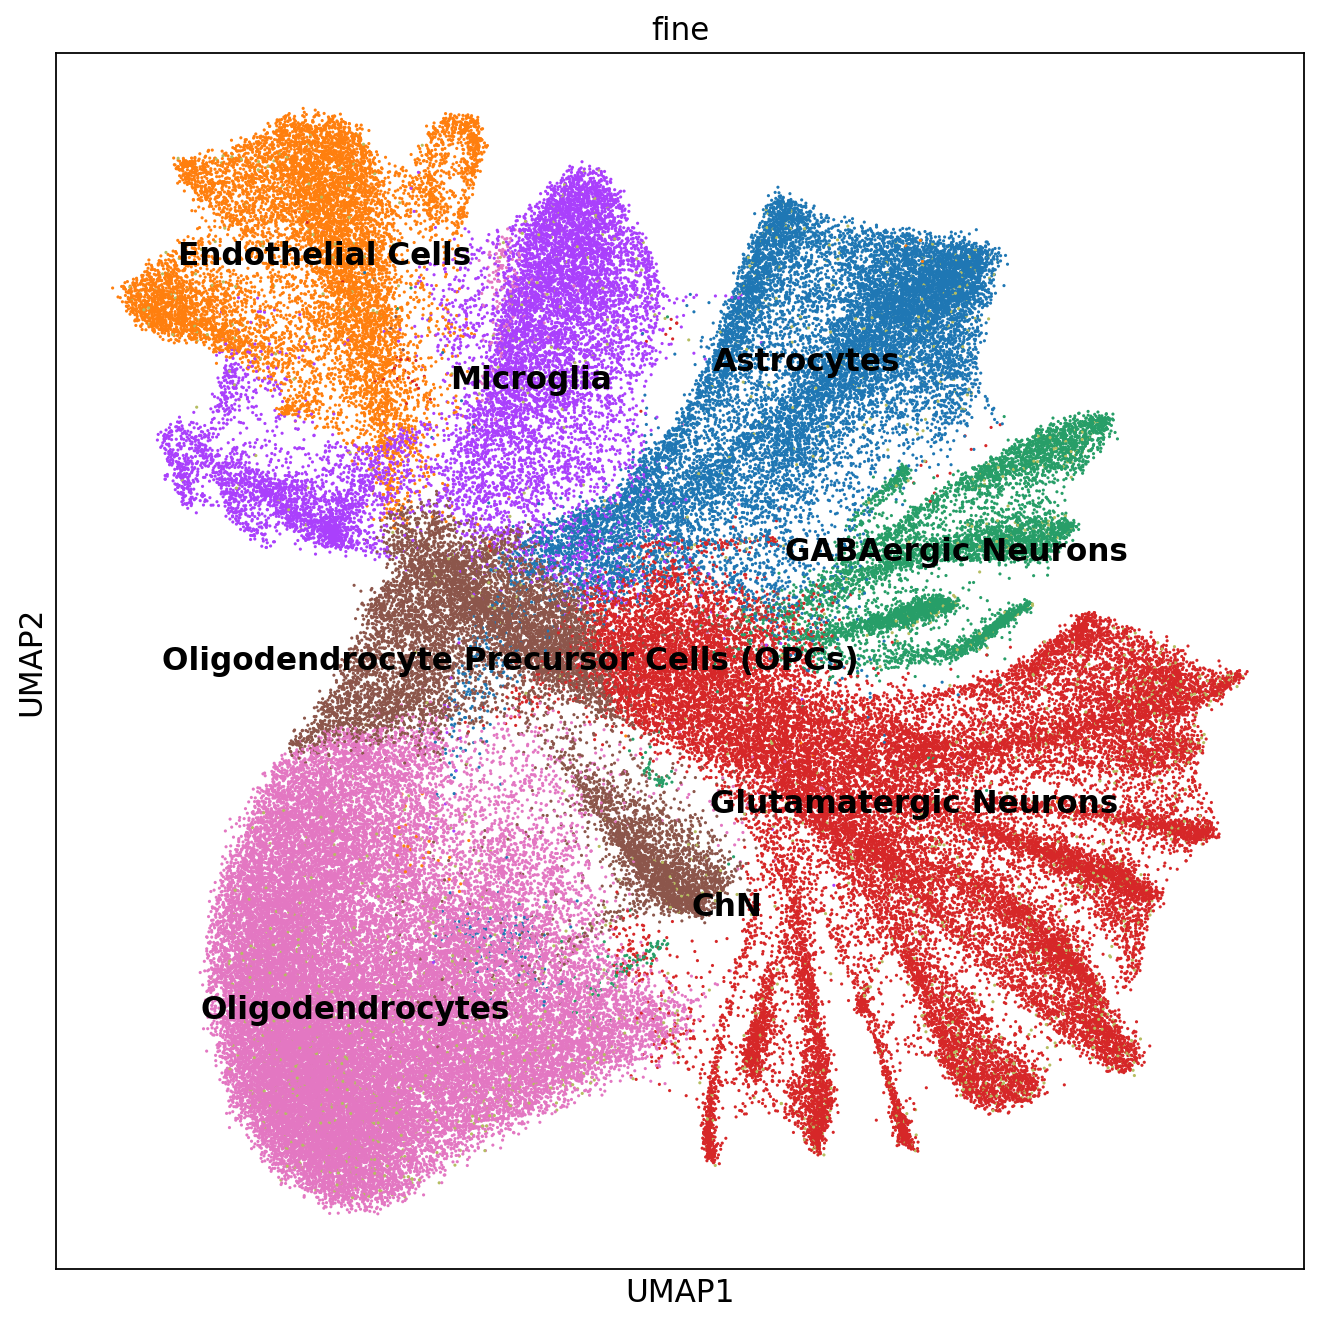

In [35]:
# Visualize the annotated UMAP with new cell types
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.umap(raw_adata, color='fine', legend_loc='on data', ax=ax, s=8)
plt.show()

# Moran's I Calculation

## Functions Definition

In [36]:
# your_project/analysis/spatial_analysis.py

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from sklearn.utils import check_random_state
from scipy.sparse import csr_matrix
from libpysal.weights import WSP
from esda.moran import Moran
from typing import List, Dict
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.spatial.distance import pdist, squareform
from anndata import AnnData
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import concurrent.futures
import warnings
import logging

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def concatenate_and_intersect(
    adata_list: list[ad.AnnData], 
    key: str = None
) -> ad.AnnData:
    """
    Concatenates a list of AnnData objects, keeping only the intersection of their variables.

    Args:
        adata_list: List of AnnData objects to concatenate.
        key: Optional key under which the batch information is stored in `obs`.

    Returns:
        Concatenated AnnData object with intersected variables.
    """
    if not adata_list:
        raise ValueError("The list of AnnData objects is empty.")
    
    common_vars = adata_list[0].var_names
    for adata in adata_list[1:]:
        common_vars = np.intersect1d(common_vars, adata.var_names)
    
    filtered_adatas = []
    for adata in adata_list:
        mask = [var_name in common_vars for var_name in adata.var_names]
        filtered_adatas.append(adata[:, mask])
    
    concatenated_adata = ad.concat(filtered_adatas, axis=0, join='outer', merge='same', label=key)
    return concatenated_adata



def hierarchical_sample(
    adata: ad.AnnData,
    groupby_cols: list[str],
    n_samples: int | float | None = None,
    fraction: float | None = None,
    random_state: int | np.random.RandomState | None = None,
) -> ad.AnnData:
    """
    Performs hierarchical random sampling of an AnnData object based on multiple categorical variables.

    Args:
        adata: The AnnData object to sample from.
        groupby_cols: A list of column names from `adata.obs` to use for hierarchical grouping.
        n_samples: The number of samples to select from each group at the final level.
                   If a float, it's interpreted as the fraction of samples to keep.
        fraction: The fraction of samples to keep from each group at the final level.
                  If provided, `n_samples` is ignored.
        random_state: Random seed for reproducibility.

    Returns:
        A new AnnData object containing the sampled cells.
    """
    import anndata as ad
    import pandas as pd
    import numpy as np
    from sklearn.utils import check_random_state

    if (n_samples is not None and fraction is not None) or (
        n_samples is None and fraction is None
    ):
        raise ValueError("Must specify exactly one of 'n_samples' or 'fraction'.")

    rng = check_random_state(random_state)

    def _sample_group(group: pd.DataFrame, level: int) -> pd.DataFrame:
        """Recursively samples from each group."""
        if level == len(groupby_cols) - 1:
            # Sample at the final level
            if fraction is not None:
                return group.sample(frac=fraction, random_state=rng)
            elif isinstance(n_samples, int):
                return group.groupby(groupby_cols[level], group_keys=False, observed=False).apply(
                    lambda x: x.sample(n=min(n_samples, len(x)), random_state=rng)
                )
            elif isinstance(n_samples, float):
                return group.sample(frac=n_samples, random_state=rng)
        else:
            # Group by the next level and sample recursively
            return group.groupby(groupby_cols[level + 1], group_keys=False, observed=False).apply(
                lambda x: _sample_group(x, level + 1)
            )

    # Starting the hierarchical sampling from the top level
    sampled_obs = _sample_group(adata.obs, level=0)
    sampled_obs_index = sampled_obs.index.get_level_values(-1) if isinstance(sampled_obs.index, pd.MultiIndex) else sampled_obs.index

    return adata[sampled_obs_index, :].copy()


def subset_anndata(
    adata: 'anndata.AnnData', 
    conditions: dict
) -> 'anndata.AnnData':
    """
    Subsets the AnnData object to only include cells where the `.obs` column values match specified conditions.

    Args:
        adata: The AnnData object to subset.
        conditions: A dictionary where keys are column names from `adata.obs` and values are the values to match in those columns.

    Returns:
        A new AnnData object containing only the cells that match all specified conditions.
    """
    import anndata as ad
    import pandas as pd
    
    # Start with a boolean mask that includes all cells
    mask = pd.Series([True] * adata.shape[0], index=adata.obs.index)
    
    # Apply each condition to the mask
    for column, value in conditions.items():
        mask &= adata.obs[column] == value
    
    # Subset the AnnData object using the mask
    return adata[mask, :].copy()


def compute_distance_matrix(embedding: np.ndarray) -> np.ndarray:
    """
    Computes the pairwise distance matrix for a given embedding.

    Args:
        embedding: A 2D numpy array where rows represent points and columns represent dimensions.

    Returns:
        A 2D numpy array representing the pairwise distance matrix.
    """
    return squareform(pdist(embedding, 'euclidean'))

def compute_weight_matrix_from_distances(distance_matrix: np.ndarray) -> np.ndarray:
    """
    Computes the weight matrix from a distance matrix using inverse distances.

    Args:
        distance_matrix: A 2D numpy array representing the pairwise distance matrix.

    Returns:
        A 2D numpy array representing the weight matrix.
    """
    with np.errstate(divide='ignore'):
        weight_matrix = 1 / distance_matrix
    np.fill_diagonal(weight_matrix, 0)  # weights for self-distance are set to zero
    return weight_matrix

def scale_values(values: np.ndarray, scaling_method: str, apply_log: bool, log_before_scaling: bool) -> np.ndarray:
    """
    Scales and optionally log-transforms the values.

    Args:
        values: The values to scale.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        The scaled (and optionally log-transformed) values.
    """
    if apply_log and log_before_scaling:
        values = np.log1p(values)

    if scaling_method == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'robust':
        scaler = RobustScaler()
    else:
        scaler = None

    if scaler is not None:
        values = scaler.fit_transform(values.reshape(-1, 1)).flatten()

    if apply_log and not log_before_scaling:
        values = np.log1p(values)

    return values

def neighbor_compute_moran_i(sub_adata: AnnData, value_key: str, category: str, use_embedding: bool = False, embedding_key: str = None, scaling_method: str = None, apply_log: bool = False, log_before_scaling: bool = False) -> dict:
    """
    Computes Moran's I spatial autocorrelation for a subset of cells.

    Args:
        sub_adata: Subset of AnnData object for specific cell type.
        value_key: The key in `sub_adata.obs` containing the values to analyze.
        category: The categorical variable in `sub_adata.obs` to group by.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `sub_adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        A dictionary with Moran's I results.
    """
    try:
        if use_embedding and embedding_key is not None:
            embedding = sub_adata.obsm[embedding_key]
            distance_matrix = compute_distance_matrix(embedding)
            weight_matrix = compute_weight_matrix_from_distances(distance_matrix)
            sparse_weight_matrix = csr_matrix(weight_matrix)
            weights = WSP(sparse_weight_matrix)
        else:
            connectivities = sub_adata.obsp['connectivities']
            weights = WSP(connectivities)
    except KeyError as e:
        raise KeyError(f"Key error: {e}")

    values = sub_adata.obs[value_key].values
    values = scale_values(values, scaling_method, apply_log, log_before_scaling)
    weights_full = weights.to_W()
    moran = Moran(values, weights_full)
    return {
        category: sub_adata.obs[category].unique()[0],
        "Moran's I": moran.I,
        "P-value": moran.p_norm,
        "num_cell": len(values)
    }

def neighbor_process_cell_type(adata: AnnData, cell_type: str, value_key: str, category: str, use_embedding: bool = False, embedding_key: str = None, scaling_method: str = None, apply_log: bool = False, log_before_scaling: bool = False) -> pd.DataFrame:
    """
    Processes a specific cell type to compute Moran's I.

    Args:
        adata: The AnnData object to analyze.
        cell_type: The specific cell type to process.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        A DataFrame with Moran's I results for the specific cell type.
    """
    mask = adata.obs[category] == cell_type
    num_cell = sum(mask)
    if num_cell > 10:
        sub_adata = adata[mask].copy()
        moranI_data = neighbor_compute_moran_i(sub_adata, value_key, category, use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling)
        return pd.DataFrame([moranI_data])
    return pd.DataFrame()





def process_cell_type(cell_type, adata, value_key, category, use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling):
    """
    Processes a specific cell type to compute Moran's I.

    Args:
        adata: The AnnData object to analyze.
        cell_type: The specific cell type to process.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.

    Returns:
        A DataFrame with Moran's I results for the specific cell type.
    """
    logging.info(f"Processing cell type: {cell_type}")
    mask = adata.obs[category] == cell_type
    num_cell = sum(mask)
    if num_cell > 10:
        sub_adata = adata[mask].copy()
        moranI_data = neighbor_compute_moran_i(sub_adata, value_key, category, use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling)
        return pd.DataFrame([moranI_data])
    else:
        logging.warning(f"No data available for cell type: {cell_type} (insufficient number of cells or other issues).")
        return pd.DataFrame()

def compute_neighbor_moran_i_by_category(
    adata: AnnData, 
    value_key: str, 
    category: str = "celltype", 
    connectivity_key: str = 'connectivities',
    use_embedding: bool = False,
    embedding_key: str = None,
    scaling_method: str = None,
    apply_log: bool = False,
    log_before_scaling: bool = False,
    max_workers: int = None,
    specific_celltype: list = None  # New argument to specify a single cell type
) -> pd.DataFrame:
    """
    Computes Moran's I spatial autocorrelation for each cell type, or a specific cell type, in parallel.

    Args:
        adata: The AnnData object to analyze.
        value_key: The key in `adata.obs` containing the values to analyze.
        category: The categorical variable in `adata.obs` to group by.
        connectivity_key: The key in `adata.obsp` containing the connectivities matrix.
        use_embedding: Whether to use embedding for distance calculation.
        embedding_key: The key in `adata.obsm` for the embedding.
        scaling_method: The method to use for scaling ('minmax', 'standard', 'robust', or None).
        apply_log: Whether to apply log transformation.
        log_before_scaling: Whether to apply log transformation before scaling.
        max_workers: The maximum number of threads to use for parallel processing.
        specific_celltype: A specific cell type to analyze. If provided, only this cell type will be analyzed.

    Returns:
        A DataFrame with Moran's I results for each cell type, or the specific cell type.
    """
    logging.info(f"Starting Moran's I computation with value key '{value_key}'.")

    # Determine the cell types to analyze
    if specific_celltype:
        logging.info(f"Analyzing specific cell type: {specific_celltype}")
        top_level_types = specific_celltype
    else:
        top_level_types = adata.obs[category].unique()
        logging.info(f"Identified {len(top_level_types)} unique cell types in category '{category}'.")

    result_df = pd.DataFrame()

    # Define a function to process each cell type, to be used with the thread pool
    def process_cell_type(cell_type):
        logging.info(f"Processing cell type: {cell_type}")
        cell_type_df = neighbor_process_cell_type(
            adata, cell_type, value_key, category, 
            use_embedding, embedding_key, scaling_method, apply_log, log_before_scaling
        )
        if cell_type_df.empty:
            logging.warning(f"No data available for cell type: {cell_type} (insufficient number of cells or other issues).")
        return cell_type_df

    # Use ThreadPoolExecutor to parallelize the execution if analyzing multiple cell types
    if len(top_level_types) > 1:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(process_cell_type, top_level_types))
    else:
        # If only one cell type is being analyzed, process it directly without parallelization
        results = [process_cell_type(top_level_types[0])]

    # Concatenate all results
    for cell_type_df in results:
        if not cell_type_df.empty:
            result_df = pd.concat([result_df, cell_type_df])

    if result_df.empty:
        logging.warning("No data was processed successfully. Returning an empty DataFrame.")
        return pd.DataFrame()

    result_df = result_df.set_index(category)
    result_df = result_df.sort_values("Moran's I", ascending=False)
    logging.info("Completed Moran's I computation.")

    return result_df





def identify_nearby_cells(
    merge_adata: ad.AnnData,
    label_column: str = 'celltype',
    target_col: str = 'datatype',
    targed_label: str = 'sn',
    threshold: float = 0.1,
    new_label_col: str = 'nearby_label'
) -> ad.AnnData:
    """
    Identifies and labels nearby cells in an AnnData object based on a threshold in the neighbor graph.

    Args:
        merge_adata: The AnnData object containing cells with connectivity information.
        label_column: The column name in `merge_adata.obs` which contains the labels for the target cells.
        target_col: The column name in `merge_adata.obs` representing labeled and unlabeled cells.
        targed_label: The label in `target_col` to consider as the source of nearby cells.
        threshold: The threshold for considering a cell "near" based on the neighbor graph connectivity.
        new_label_col: The column name to store new labels for nearby cells.

    Returns:
        A new AnnData object containing only the nearby cells that were identified.
    """
    import anndata as ad
    import numpy as np

    celltypes = merge_adata.obs[label_column].unique()
    merge_adata.obs[new_label_col] = 'unlabeled'  # Default value for cells that are not nearby
    nearby_cellbin_indices_dict = {}

    for celltype in celltypes:
        print(f"Processing celltype: {celltype}")
        sn_mask = (merge_adata.obs[target_col] == targed_label) & (merge_adata.obs[label_column] == celltype)
        cellbin_mask = (merge_adata.obs[target_col] != targed_label) & (merge_adata.obs[label_column] == celltype)
        neighbor_graph = merge_adata.obsp['connectivities']
        sn_indices = np.where(sn_mask)[0]
        cellbin_indices = np.where(cellbin_mask)[0]

        if len(sn_indices) == 0 or len(cellbin_indices) == 0:
            print(f"No labeled or unlabeled cells found for celltype: {celltype}")
            continue

        neighbor_sums = neighbor_graph[sn_indices].sum(axis=0)
        neighbor_sums = np.asarray(neighbor_sums).flatten()
        nearby_cellbin_indices = cellbin_indices[neighbor_sums[cellbin_indices] > threshold]

        if len(nearby_cellbin_indices) > 0:
            nearby_cellbin_indices_dict[celltype] = nearby_cellbin_indices
            merge_adata.obs.loc[merge_adata.obs.index[nearby_cellbin_indices], new_label_col] = f'near_{celltype}'
        else:
            print(f"No nearby unlabeled cells found for celltype: {celltype}")

    all_nearby_cellbin_indices = np.concatenate(list(nearby_cellbin_indices_dict.values()))
    print(f"Total nearby unlabeled cells found: {merge_adata[all_nearby_cellbin_indices].shape[0]}")

    return merge_adata[all_nearby_cellbin_indices].copy()


In [37]:
from scipy.spatial import cKDTree

In [38]:

test_df = raw_adata.obs.copy()

In [39]:

mask = test_df["fine"] == "ChN"
tree = cKDTree(raw_adata[mask].obsm["spatial"])
dist, idx = tree.query(raw_adata.obsm["spatial"])
test_df["chn_dist"] = dist

In [40]:
raw_adata.obs = test_df

In [41]:
df = compute_neighbor_moran_i_by_category(raw_adata, value_key="chn_dist", category = "fine", use_embedding=True, 
                                          embedding_key="X_pca")

2024-09-26 18:31:06,602 - INFO - Starting Moran's I computation with value key 'chn_dist'.
2024-09-26 18:31:06,608 - INFO - Identified 8 unique cell types in category 'fine'.
2024-09-26 18:31:06,612 - INFO - Processing cell type: Oligodendrocyte Precursor Cells (OPCs)
2024-09-26 18:31:06,613 - INFO - Processing cell type: Oligodendrocytes
2024-09-26 18:31:06,622 - INFO - Processing cell type: ChN
2024-09-26 18:31:06,623 - INFO - Processing cell type: Endothelial Cells
2024-09-26 18:31:06,625 - INFO - Processing cell type: Microglia
2024-09-26 18:31:06,657 - INFO - Processing cell type: Glutamatergic Neurons
2024-09-26 18:31:06,657 - INFO - Processing cell type: Astrocytes
2024-09-26 18:31:06,680 - INFO - Processing cell type: GABAergic Neurons
/public/home/jijh/micromamba/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

: 

In [43]:
df

,Moran's I,P-value,num_cell
fine,,,
Microglia,0.075934,0.0,11231
Oligodendrocyte Precursor Cells (OPCs),0.004809,0.0,10319
Endothelial Cells,0.004364,0.0,10100
Glutamatergic Neurons,0.001758,0.0,31565
GABAergic Neurons,0.001610,0.0,6493
Astrocytes,0.001406,0.0,15407
Oligodendrocytes,0.001236,0.0,38429
ChN,NaN,NaN,2511


In [45]:
import os

In [57]:
os.getcwd()

'/public/home/jijh/st_project/downloads/external_proof'

In [56]:
raw_adata

AnnData object with n_obs × n_vars = 126055 × 960
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Rb-APP_raw', 'Anti-Rb-APP_high_pass', 'Anti-Ms-pTau_raw', 'Anti-Ms-pTau_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'cell_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'cell_type', 'fine', 'chn_dist'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'fine_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [58]:
df

,Moran's I,P-value,num_cell
fine,,,
Microglia,0.075934,0.0,11231
Oligodendrocyte Precursor Cells (OPCs),0.004809,0.0,10319
Endothelial Cells,0.004364,0.0,10100
Glutamatergic Neurons,0.001758,0.0,31565
GABAergic Neurons,0.001610,0.0,6493
Astrocytes,0.001406,0.0,15407
Oligodendrocytes,0.001236,0.0,38429
ChN,NaN,NaN,2511


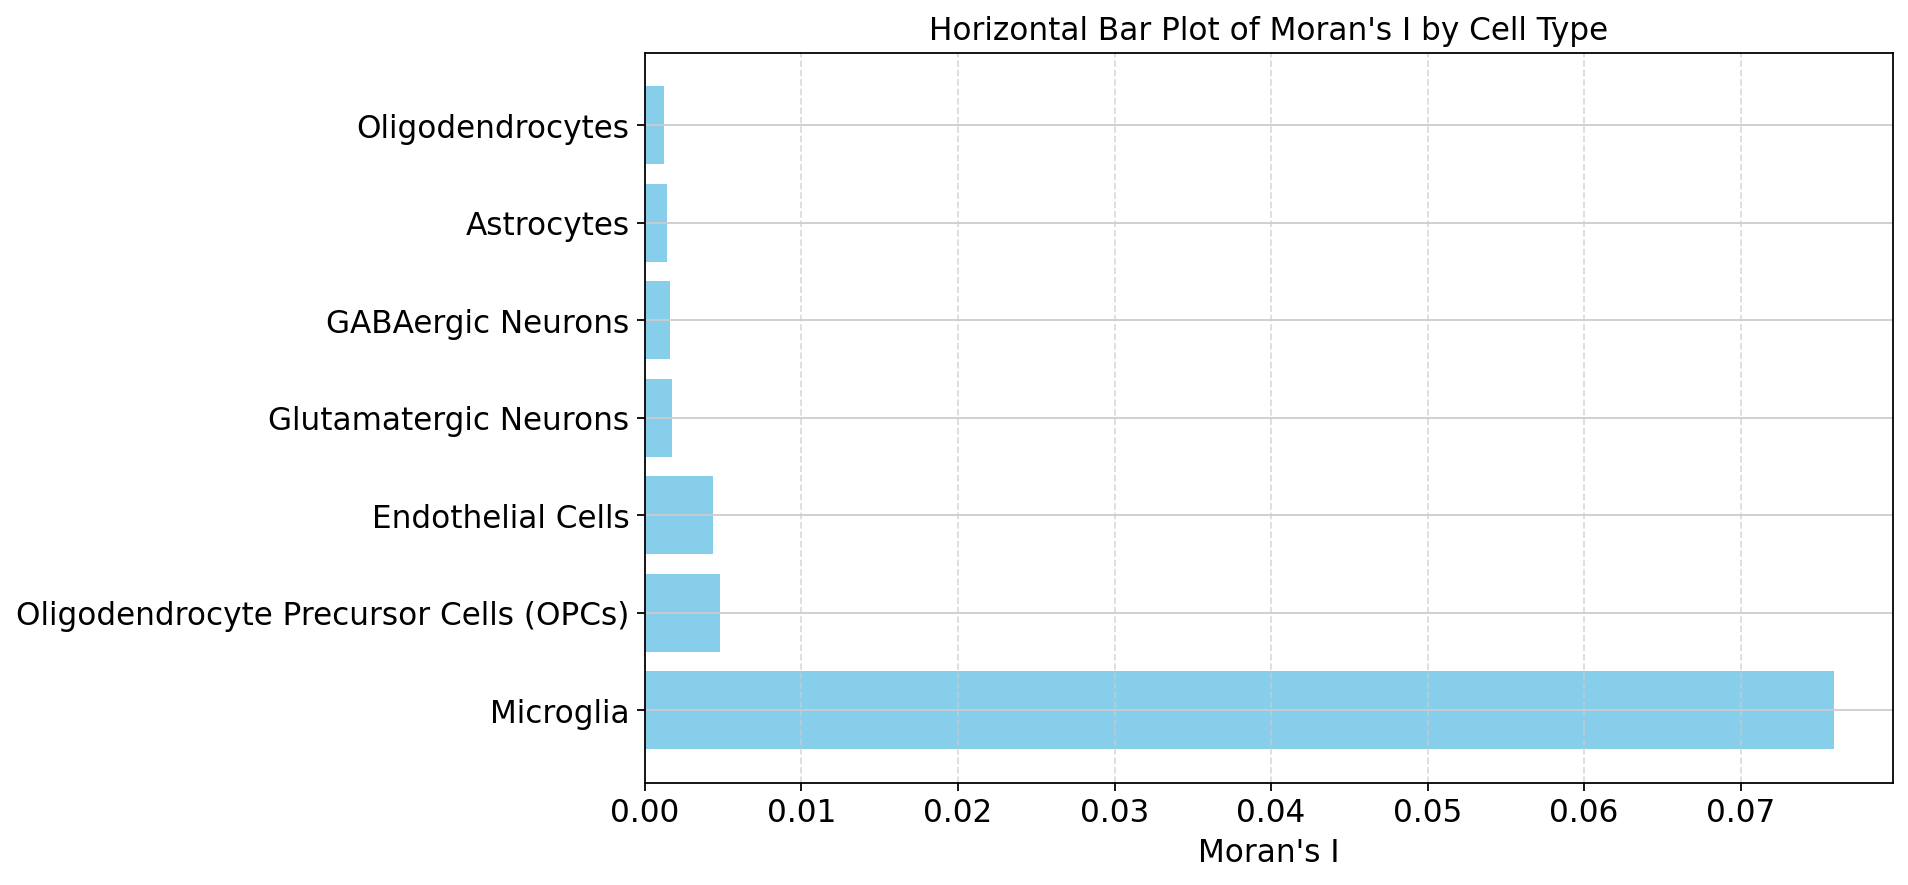

In [59]:
# Plotting the horizontal bar plot for "Moran's I" column
df_clean = df.dropna(subset=["Moran's I"])  # Removing rows with NaN in "Moran's I"

plt.figure(figsize=(10, 6))
plt.barh(df_clean.index, df_clean["Moran's I"], color='skyblue')
plt.xlabel("Moran's I")
plt.title("Horizontal Bar Plot of Moran's I by Cell Type")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

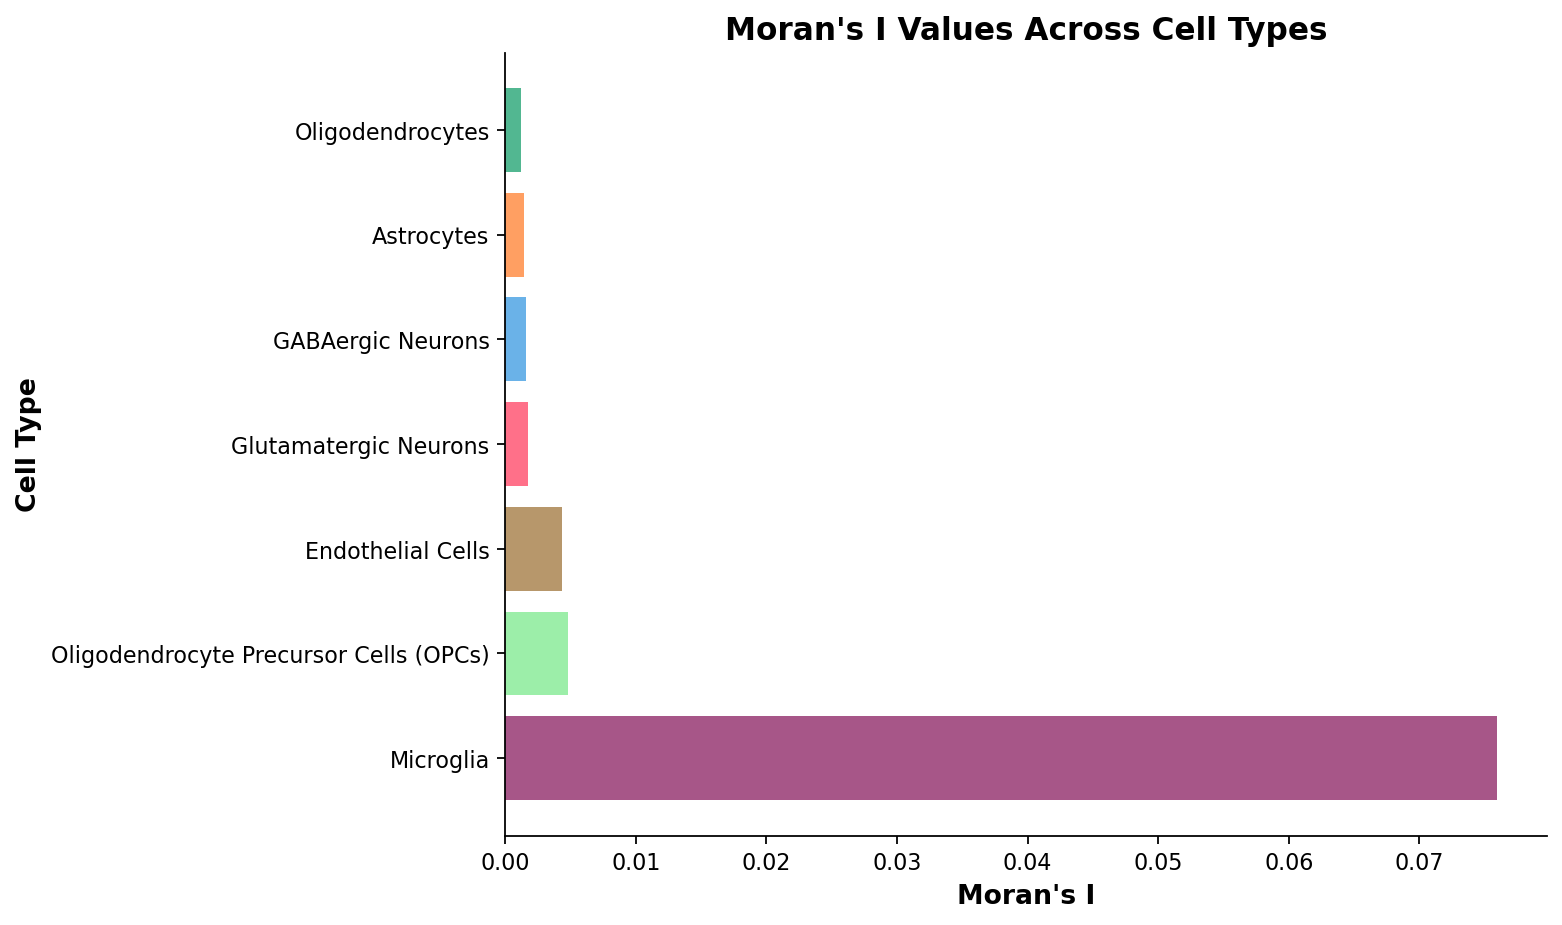

In [65]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Your colors for cell types
general_type_colors = {
    'ExN': '#FF3357',
    'InN': '#2B92DF',
    'Astro': '#FF7620',
    'Micro': '#820E56',
    'Olig': '#099963',
    'OPC': '#73E785',
    'Vas': '#523691',
    'Endo': '#996B2D',
    'MSN': '#0D46A0',
    'Peri': '#858781',
    'SMC': '#825F45'
}

# Mapping the cell types to these categories
cell_type_colors = {
    'Microglia': general_type_colors['Micro'],
    'Oligodendrocyte Precursor Cells (OPCs)': general_type_colors['OPC'],
    'Endothelial Cells': general_type_colors['Endo'],
    'Glutamatergic Neurons': general_type_colors['ExN'],
    'GABAergic Neurons': general_type_colors['InN'],
    'Astrocytes': general_type_colors['Astro'],
    'Oligodendrocytes': general_type_colors['Olig']
}

# Assuming df_clean is your DataFrame with cell types as the index
bar_colors = [cell_type_colors[cell] for cell in df_clean.index]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.barh(df_clean.index, df_clean["Moran's I"], color=bar_colors, edgecolor=None, alpha=0.7)
plt.xlabel("Moran's I", fontsize=12, fontweight='bold')
plt.ylabel("Cell Type", fontsize=12, fontweight='bold')
plt.title("Moran's I Values Across Cell Types", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)

# Removing chart spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save to PDF with text preserved
pdf_filename = 'moran_i_values_across_cell_types.pdf'
with PdfPages(pdf_filename) as pdf:
    plt.tight_layout()
    pdf.savefig()  # saves the current figure
    plt.close()    # close the figure to free memory

print(f"Plot saved as {pdf_filename}")


In [67]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


# Assuming df_clean is your DataFrame with cell types as the index
bar_colors = [cell_type_colors[cell] for cell in df_clean.index]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.barh(df_clean.index, df_clean["Moran's I"], color=bar_colors, edgecolor=None, alpha=0.7)
plt.xlabel("Moran's I", fontsize=12, fontweight='bold')
plt.ylabel("Cell Type", fontsize=12, fontweight='bold')
plt.title("Moran's I Values Across Cell Types", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)

# Removing chart spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save to PDF with text preserved
pdf_filename = './moran_i_values_across_cell_types.pdf'
with PdfPages(pdf_filename) as pdf:
    plt.tight_layout()
    pdf.savefig()  # saves the current figure
    plt.close()    # close the figure to free memory

print(f"Plot saved as {pdf_filename}")


Plot saved as ./moran_i_values_across_cell_types.pdf
